# q3dfit example notebook: rest-frame mid-IR, mock MIRI ETC cube of quasar

<h3><font color='teal'>Installation of the environment and the package are described <a href="https://q3dfit.readthedocs.io/">here</a>. </font></h3>

This Jupyter notebook allows you to run Q3Dfit, a PSF decomposition and spectral analysis package tailored for JWST NIRSpec and MIRI IFU observations. 

Q3Dfit is developed as a science-enabling data product by the Early Release Science Team #1335 Q3D. You can find more information about this ERS program **Q3D** [here](https://wwwstaff.ari.uni-heidelberg.de/dwylezalek/q3d.html) and [here](https://www.stsci.edu/jwst/science-execution/approved-programs/dd-ers/program-1335).

The software is based on the existing package IFSFIT developed by Dave Rupke (see [ADS link](https://ui.adsabs.harvard.edu/abs/2017ApJ...850...40R/abstract)).

The following notebook will guide you through the initialization procedure and will then perform the analysis. 

## Table of Contents

* [1. Initialization](#chapter1)
    * [1.0. Setting up the directory tree](#chapter1_0)
    * [1.1. Setting up the data and models](#chapter1_1)
    * [1.2. Setting up the fitting parameters](#chapter1_2)
        * [1.2.1. Emission line parameters](#chapter1_2_1)
        * [1.2.2. Continuum parameters](#chapter1_2_2)
    * [1.3. Setting up the plotting parameters](#chapter1_3)
* [2. Run fitting and plotting routines](#chapter2)

## 1. Initialization <a class="anchor" id="chapter1"></a>

In [1]:
import os.path
import numpy as np
%matplotlib inline
# unless you are running this python notebook from the directory where q3dfit is installed, you need to point the
# path to the package in order to import it. 
import sys
sys.path.append("")
sys.path.append("../")

In [2]:
# if QUESTFIT is needed, in mid-IR
from q3dfit.questfit_readcf import readcf

In [3]:
# Convenience function
# Ref: https://github.com/spacetelescope/jwebbinar_prep/blob/main/imaging_mode/imaging_mode_stage_1.ipynb
from astropy.utils.data import download_file
def download_files(files, output_directory, force=False):
    """Given a tuple or list of tuples containing (URL, filename),
    download the given files into the current working directory.
    Downloading is done via astropy's download_file. A symbolic link
    is created in the specified output dirctory that points to the
    downloaded file.
    
    Parameters
    ----------
    files : tuple or list of tuples
        Each 2-tuple should contain (URL, filename), where
        URL is the URL from which to download the file, and
        filename will be the name of the symlink pointing to
        the downloaded file.
        
    output_directory : str
        Name of the directory in which to create the symbolic
        links to the downloaded files
        
    force : bool
        If True, the file will be downloaded regarless of whether
        it is already present or not.
                
    Returns
    -------
    filenames : list
        List of filenames corresponding to the symbolic links
        of the downloaded files
    """
    # In the case of a single input tuple, make it a
    # 1 element list, for consistency.
    filenames = []
    if isinstance(files, tuple):
        files = [files]
        
    for file in files:
        filenames.append(file[1])
        if force:
            print('Downloading {}...'.format(file[1]))
            demo_file = download_file(file[0], cache='update')
            # Make a symbolic link using a local name for convenience
            if not os.path.islink(os.path.join(output_directory, file[1])):
                os.symlink(demo_file, os.path.join(output_directory, file[1]))
        else:
            if not os.path.isfile(os.path.join(output_directory, file[1])):
                print('Downloading {}...'.format(file[1]))
                demo_file = download_file(file[0], cache=True)
                # Make a symbolic link using a local name for convenience
                os.symlink(demo_file, os.path.join(output_directory, file[1]))
            else:
                print('{} already exists, skipping download...'.format(file[1]))
                continue
    return filenames    

### 1.0. Setting up the directory tree <a class="anchor" id="chapter1_0"></a>

Define the directories in which your data cube(s) that you want to analyse are stored and the output directories. We recommend creating a working directory that you name after your target, in which all outputs from Q3Dfit will be saved. 

In [4]:
# Base directory (book-keeping)
volume = os.path.normpath('./MIRI_ETC_sim/') # base directory

# Input directory
indir = volume
if not os.path.exists(indir):
    os.makedirs(indir)
infile = os.path.join(volume, 'miri_etc_cube.fits') # path + name of your input cube
cfinfile = os.path.join(volume, 'miritest.cf')
qsotemplate = os.path.join(volume, 'miri_qsotemplate.npy')

# Output directories/files
outdir = volume # path + name of directory for saving the output files
if not os.path.exists(outdir):
    os.makedirs(outdir)
logfile = os.path.join(outdir, 'miritest_fitlog.txt') # path to output logfile

# Initialization file (q3di.npy) directory
initdir = outdir

In [5]:
# Base directory (book-keeping)
volume = 'MIRI-ETC-sim/'
# prefix label for output files
gal = 'MIRI-ETC-sim'
# Input directory
indir = volume
if not os.path.exists(indir):
    os.makedirs(indir)
# Output directory
outdir = volume
if not os.path.exists(outdir):
    os.makedirs(outdir)
# Initialization file (q3di.npy) directory
initdir = volume
# Output logfile
logfile = os.path.join(outdir, gal+'-fitlog.txt')

Download data from public Box folder. <font color='red'> Note: This also downloads the *.cf configuration file (specifying which spectral components to include in the MIR fitting). We note that the format of this file is currently under development and it will in the future be superseded by a more readable/convenient option. For a current description of continuum fitting parameters in the .cf file, please see the documentation: 
https://q3dfit.readthedocs.io/en/latest/

In [6]:
# make tuples of urls and download filenames
# infile = mock data cube
# cf = config file
infile_tup = ('https://rhodes.box.com/shared/static/1lgon36wkq25dv675wjdvrnodtban7o7.fits', 'miri_etc_cube.fits')
cf_tup = ('https://rhodes.box.com/shared/static/b46ofbgs5tjt3jsayfms54i1sgktv5yn.cf', 'miritest.cf')
# download files; by default don't force overwrite and take first element of output
infile = download_files(infile_tup, indir, force=False)[0]
cfinfile = download_files(cf_tup, indir, force=False)[0]
# add subdirectory to filenames
infile = os.path.join(indir, infile)
cfinfile = os.path.join(indir, cfinfile)

miri_etc_cube.fits already exists, skipping download...
miritest.cf already exists, skipping download...


### 1.1. Setting up the data and models <a class="anchor" id="chapter1_1"></a>

Some general information about your cube. `argsreadcube` is a dictionary of attributes sent to the `CUBE` class.
- For non-JWST data, set `wmapext` to `None`. The WMAP extension is a [3-D weight image](https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/science_products.html) giving the relative weights of the output spaxels.
- Microns are the wavelength unit used internally, but `q3dfit` can accept other wavelength input units or output other units.
- The code does calculations in flambda space, but assumes input units of MJy/sr, the JWST default. Other input wavelength units can be specified.

Some general information about your cube:

In [7]:
from q3dfit.readcube import Cube
argsreadcube = {'wmapext': None,
                'waveunit_in': 'Angstrom',
                'fluxunit_in': 'Jy'}

if not os.path.isfile(infile): 
    print('Data cube not found.')
else:
    cube = Cube(infile, **argsreadcube)
    ncols = cube.ncols # number of columns
    nrows = cube.nrows # number of rows
    cube.about()

if not os.path.isfile(cfinfile):
    print('Configuration file not found.')
else:
    config_file = readcf(cfinfile)

Size of data cube: [ 16 , 25 , 907 ]
Wavelength range: [ 11.53050463300101 , 13.47485667410414 ]  micron


Name and systemic redshift of the galaxy. `zsys` is presently not used within the code, but would be an input for, e.g., calculating velocity maps in routines under development (e.g., `makemaps.py`). It is used in this notebook in initializing the arrays of initial guesses below.

In [8]:
name = 'miri-etc-quasar'
zsys_gas = 0.0

Wavelength range over which to fit data. The user can also specify sets of regions to ignore in the fit.

In [9]:
fitrange = [11.53,13.47] # in micron

Create quasar template from the central spaxel of the spatially-unbinned data cube.

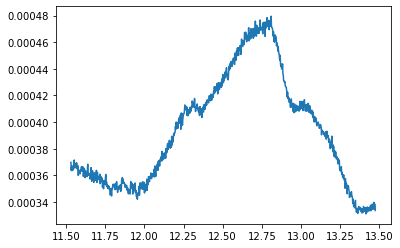

In [10]:
from q3dfit.makeqsotemplate import makeqsotemplate
#makeqsotemplate(infile, os.path.join(outdir, 'miritest.npy'), wmapext=None)
makeqsotemplate(infile, os.path.join(outdir, 'miritest.npy'), argscube=argsreadcube)
qsotemplate = os.path.join(outdir, 'miritest.npy')

### 1.2. Setting up the fitting parameters<a class="anchor" id="chapter1_2"></a>

#### 1.2.1. Emission-line parameters <a class="anchor" id="chapter1_2_1"></a>

What lines do you want to fit? You can choose from the linelists [here](https://github.com/Q3D/q3dfit/tree/main/data/linelists), or in `q3dfit/data/linelists/`.

In [11]:
lines = ['[NeII]12.81']

How many components do you want to be fitted to the emission lines?

In [12]:
maxncomp = 1

This block sets up initial conditions for the emission-line fit to each spaxel. Emission lines are set to a common redshift and velocity dispersion. However, different sets of emission lines can have different velocities and linewidths by specifying different lines to which to tie particular emission lines.

In [13]:
linetie = dict()
ncomp = dict()
zinit_gas = dict()
siginit_gas = dict()
for i in lines:
    linetie[i] = '[NeII]12.81'
    ncomp[i] = np.full((ncols,nrows),maxncomp)
    zinit_gas[i] = np.full((ncols,nrows,maxncomp),0.)
    siginit_gas[i] = np.full((ncols,nrows,maxncomp), 500.)

`siglim_gas` sets lower and upper bounds for the Gaussian width (sigma) of the emission line. These limits can be set globablly, for all spaxels and components, by defining a 2-element array. The limits can also be set for individual spaxels (but all components) by defining an (Ncol x Nrow x 2) array.

In [14]:
siglim_gas = np.array([5., 1000.])

#### Spectral resolution convolution
##### Just running convolution ---

If no convolution is desired, then set `spectres_convolve` to None. 
If convolution is desired, then `spectres_convolve` and `spect_instrum` are required variables.

Specify the desired convolution method using `spect_instrum`. The syntax is: 
`spect_instrum = {INSTRUMENT:[METHOD]}`, which should mirror the filename in `q3dfit/data/dispersion_files/`. METHOD specifies the grating, spectral resolution [R], Δλ FWHM in [Å], velocity in [km/s].

Examples convolving with: 
1. flat R=500: `spect_instrum = {'flat':['R500']}`
2. flat velocity FWHM = 30km/s: `spect_instrum = {'flat':['kms30']}`
3. flat Δλ FWHM = 4 Å: `spect_instrum = {'flat':['dlambda4']}`
4. JWST NIRSPEC / G140M: `spect_instrum = {'JWST_NIRSPEC':['G140M']}`

If desired flat convolution file does not exist, then a new file will be created automatically. 

In [15]:
spect_instrum = {'JWST_MIRI':['CH3A']}
spectres_convolve = {'ws_instrum':spect_instrum}

##### Creating convolution files (optional) ---

If the user wants to create a dispersion file, there are 2 methods:

1. First, run `from q3dfit.common.spectConvol import dispFile` and initialize: `dispObj = dispFile()`
2. Create the files with either method A or B

2.(A) Create a flat R=120 dispersion file from 10 μm to 30 μm: 

`dispObj.make_dispersion(120,WAVELEN=[10,30],TYPE='R')`

2.(B) Create a custom dispersion file with user supplied wavelength and Resolving power lists:

`dispObj.make_custom_dispersion([wavelen list],R=[some R list],FILENAME='custom_RlistA_disp')`

3. Specify desired dispersion file in convolution: running custom example 2B

`spect_instrum = {'custom':['RlistA']}`


In [16]:
#from q3dfit.spectConvol import dispFile
#dobj = dispFile()
#dispObj.make_custom_dispersion([wavelen list],R=[some R list],FILENAME='custom_RlistA_disp')
#spect_instrum = {'custom':['RlistA']}

#### 1.2.2 Continuum  parameters <a class="anchor" id="chapter1_2_2"></a>

`q3dfit` first masks emission lines before fitting. This sets is the default mask value in km/s for each velocity component for the first fit. During the second fit, the mask value is set automatically using the best-fit linewidths determined from the first fit.

In [17]:
maskwidths_def = 1000.

The continuum fitting parameters specified here are for the case of general MIR fitting.

In [18]:
fcncontfit = 'questfit'
argscontfit = dict()
argscontfit['config_file'] = cfinfile
argscontfit['outdir'] = outdir

The mid-IR continuum fitting includes features that depend on redshift. These are specified as "stellar" redshift for compatibility with stellar template fitting, even though they refer in this case to the redshift of the mid-IR dust features.

In [19]:
zinit_stars = np.full((ncols,nrows),0.0)

### 1.3. Setting up the plotting and output parameters <a class="anchor" id="chapter1_3"></a>

One dictionary must be defined for a line plot to appear. `argspltlin1` holds the options for the first line plot, and `argspltlin2` is for the second. Parameter options are fed in as keyword/data pairs.

Required keywords in each dictionary:
* `nx`: Number of subplots in the horizontal direction
* `ny`: Number of subplots in the vertical direction
* Options for centerting the plot:
    - `line`: a string list of line labels
    - `center_obs`: a float list of wavelengths of each subplot center, in the observed (plotted) frame
    - `center_rest`: a float list of wavelengths of each subplot center, in the rest frame, which are converted to obs. frame

Optional keywords:
* `size`: float list of widths in wavelength space of each subplot; if not specified, default is 300 $Å$
* `IR`: set to `True` to use infrared-style plot

In [20]:
argspltlin1 = {'nx': 1,
               'ny': 1,
               'line': lines,
               'size': [1.]}

Set this input to `q3da` to specify that the quasar and host contributions should be separated in the output files.

In [21]:
decompose_qso_fit = True

The following cell will create the initialisation structure. **Do not change anything in this cell.** 

In [22]:
q3di = {# Required pars
        'fcninitpar': 'parinit',
        'fitran': fitrange,
        'infile': infile,
        'label': config_file['source'][0].replace('.ideos','').replace('.npy', ''),
        'lines': lines,
        'linetie': linetie,
        'maxncomp': maxncomp,
        'ncomp': ncomp,
        'outdir': outdir,
        'zinit_stars': zinit_stars,
        'zinit_gas': zinit_gas,
        'zsys_gas': zsys_gas,
        # Optional pars
        'argsreadcube': argsreadcube,
        'argscontfit': argscontfit,
        'argspltlin1': argspltlin1,
        'decompose_qso_fit': decompose_qso_fit,
        'fcncheckcomp': 'checkcomp',
        'fcncontfit': fcncontfit,
        'logfile': logfile,
        'maskwidths_def': maskwidths_def,
        'siglim_gas': siglim_gas,
        'siginit_gas': siginit_gas,
        'spect_convol':spectres_convolve
        }

If you want to run `q3dfit` in batch mode, run this cell, which saves q3di to an `npy` file. In your python command line, read in file and run `q3dfit` with
<pre><code>q3di = '/path/to/the/npy/file/q3di.npy'
from q3dfit.q3df import q3df
q3df(q3di,cols=cols,rows=rows)</code></pre>

In [23]:
q3di_npy = 'q3di.npy'
np.save(os.path.join(initdir, q3di_npy,q3di))

## 2. Run fitting and plotting routines <a class="anchor" id="chapter2"></a>

In [24]:
from q3dfit.q3df import q3df
from q3dfit.q3da import q3da

Choose columns and rows to fit. Ranges are specified as two-element lists specifying the first and last spaxel.

In [25]:
cols = 6
rows = 12

Run the fit. Choose `quiet=False` for verbose output. An output dictionary for each spaxel is saved to a numpy binary file labeled with prefix `q3di['label']` and suffix `_col_row.npy`.

In [26]:
q3df(q3di, cols=cols, rows=rows, quiet=False)

[col,row]=[6,12] out of [16,25]
FITLOOP: First call to FITSPEC
1.0
1
[[Variables]]
    template_0_amp:        0.04720001 (init = 0.059)
    template_0_multpolyA:  5.3464e-05 (init = 1)
    template_0_multpolyB:  1.99994570 (init = 1)
    template_0_multpolyC:  1.99999834 (init = 0.1)
    template_1_amp:        2.2768e-11 (init = 2.528462e-05)
    blackbody250a:         1.0066e-11 (init = 0.1)
    blackbody250T:         2999.61487 (init = 250)
    global_ext_Av:         3.4227e-15 (init = 0)
    global_ice_tau:        1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.5 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.8015e+11                                    1.35e+01    
       1              2         3.8015e+11      1.35e+01       1.00e-10       6.76e-02    
Both `ftol` and `xtol` termination conditions are satisfied.
Function evaluations 2, initial cost 3.8015e+11, final cost 3.8015e+11, first-order op

Plot the results. The resulting plots are saved as `.jpg` files. Data from multiple spaxels are collated into dictionaries containing emission-line and continuum best-fit parameters and saved to various ancillary files.

<h5><font color='red'> Warning: The QSO-host decomposition plotted in this section is still in development and not fit for scientific purposes. The results will be strongly affected by the spatial distribution of the PSF. </font></h5>

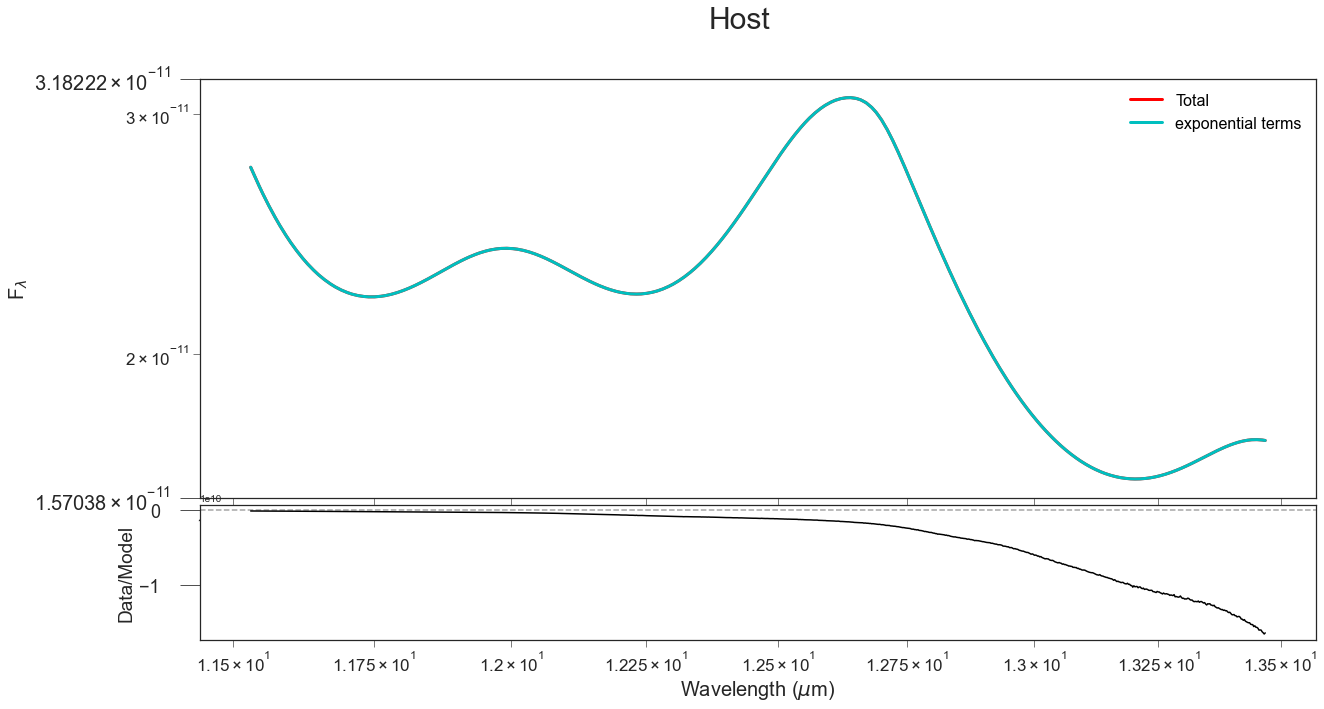

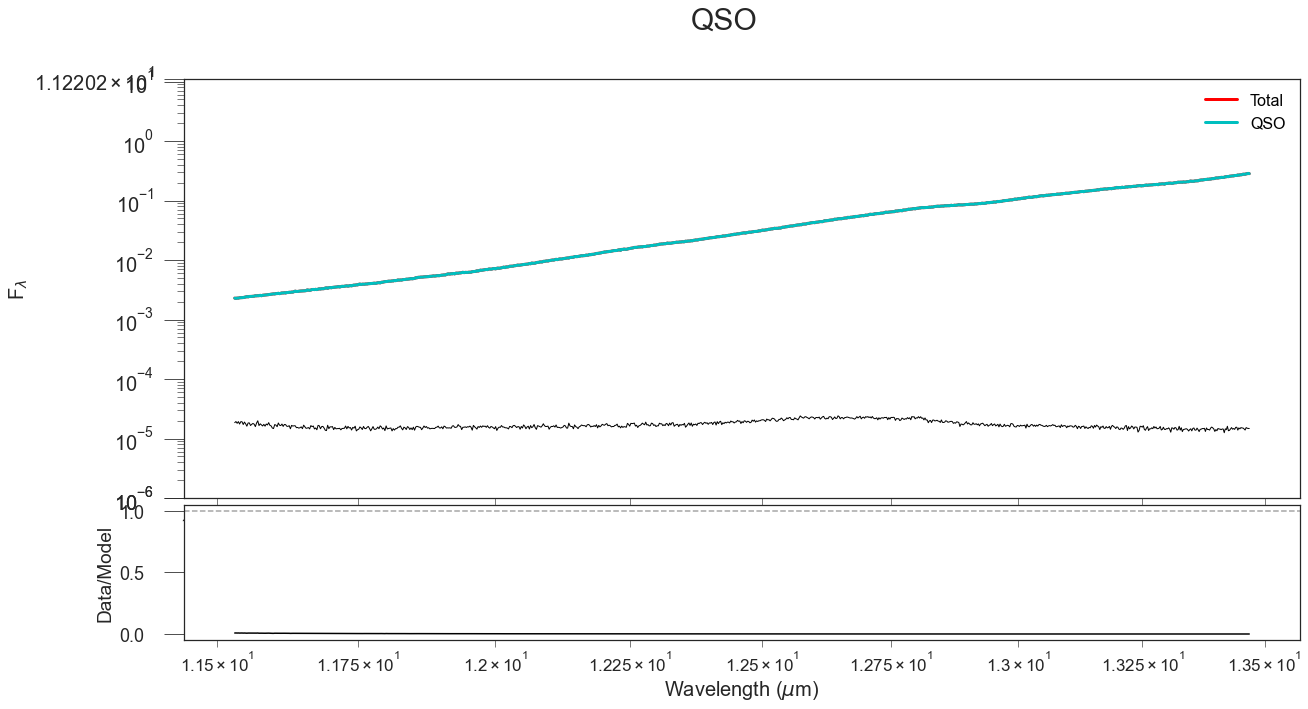

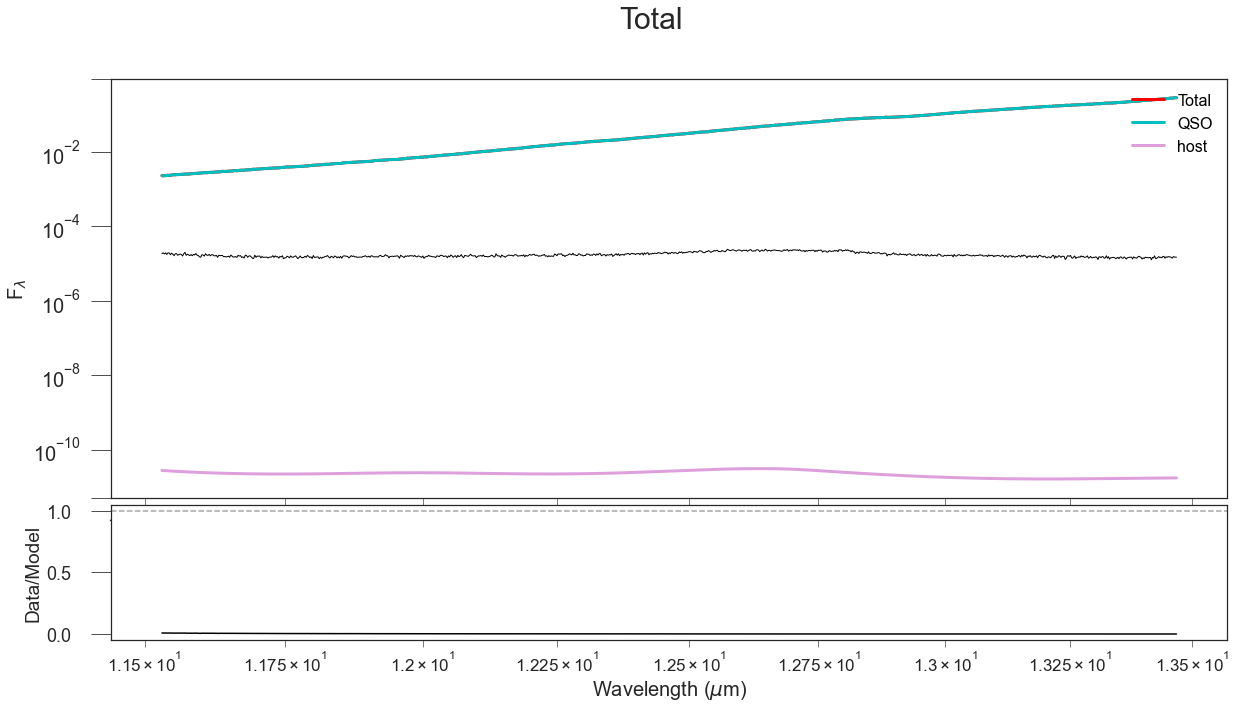

In [27]:
q3da(q3di, cols=cols, rows=rows)